## Applied Machine Learning Homework 3 Task 6

Peter Grantcharov (pdg2116), Po-Chieh Liu (pl2441)

**The overall goal is to predict whether a payment by a company to a medical doctor or facility was made as part of a research project or not.**

In [1]:
# import base packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Task 6 An explainable model
Can you create an “explainable” model that is nearly as good as your best model? An explainable model should be small enough to be easily inspected - say a linear model with few enough coefficients that you can reasonable look at all of them, or a tree with a small number of leafs etc

### Import data

In [2]:
# Selected features
col  = ['Recipient_State',
        'Recipient_Country',
        'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID',
        'Total_Amount_of_Payment_USDollars', 
        'Date_of_Payment', 
        'Form_of_Payment_or_Transfer_of_Value',
        'Dispute_Status_for_Publication', 
        'Related_Product_Indicator',
        'Covered_or_Noncovered_Indicator_1',
        'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1',
        'Covered_or_Noncovered_Indicator_2',
        'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_2',
        'Covered_or_Noncovered_Indicator_3',
        'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_3',
       ]

# import file 1 and 2
file1 = pd.read_csv('OP_DTL_GNRL_PGYR2017_P01182019.csv', usecols = col)
file2 = pd.read_csv('OP_DTL_RSRCH_PGYR2017_P01182019.csv', usecols = col)

# Labeling
file1['y'] = int(0)
file2['y'] = int(1)

# combine (vertical stack)
df = pd.concat([file1, file2], sort = False)

# free memory
del file1, file2, col

# convert to datatime type and reduce to month only
df['Date_of_Payment'] = pd.to_datetime(df.Date_of_Payment, format = "%m/%d/%Y")
df['Date_of_Payment'] = pd.DatetimeIndex(df['Date_of_Payment']).month


### Deal with missing data

In [42]:
# Labelling all missing states as "Unknown"
df.Recipient_State[df.Recipient_State.isnull()] = 'Unknown'

# Grouping all non-us countries and United States Minor Outlying Islands together
df.Recipient_Country[~(
    (df.Recipient_Country == 'United States') |  (df.Recipient_Country.isnull()))] = 'Other'

# assign missing country as unknown country
df.Recipient_Country[df.Recipient_Country.isnull()] = 'Unknown'

# Assign not applicable for missing value
df.Covered_or_Noncovered_Indicator_1[df.Covered_or_Noncovered_Indicator_1.isnull()] = 'M1'
df.Covered_or_Noncovered_Indicator_2[df.Covered_or_Noncovered_Indicator_2.isnull()] = 'M2'
df.Covered_or_Noncovered_Indicator_3[df.Covered_or_Noncovered_Indicator_3.isnull()] = 'M3'

# if the Related_Product_Indicator indicator is Yes, then at least 1 item should be related
# so assume the missing of 1st indicator is missing
for i in range(1, 4):
    name = 'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_' + str(i)
    df[name][( (df.Related_Product_Indicator == 'Yes') & (df[name].isnull()))] = 'Unknown' + str(i)

    # The missing indicator 1 with No of related indicator should be NA
    df[name][((df.Related_Product_Indicator == 'No'))] = 'NA' + str(i)


## Build model

In [43]:
# import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [44]:
# metric we want to use
scoring = {'balanced_accuracy' : 'balanced_accuracy',
           'precision' : 'precision',
           'average_precision' : 'average_precision', 
           'recall' : 'recall',
           'f1' : 'f1'}

In [63]:
# subset features
selected_feature = ['Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID',
                    'Total_Amount_of_Payment_USDollars',
                    'Form_of_Payment_or_Transfer_of_Value',
                    'Covered_or_Noncovered_Indicator_1']

## Smooth Target-based Encoding

In [66]:
# Source: https://maxhalford.github.io/blog/target-encoding-done-the-right-way/

def calc_smooth_mean(df, by, on, m):
    # Compute the global mean
    mean = df[on].mean()

    # Compute the number of values and the mean of each group
    agg = df.groupby(by)[on].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']

    # Compute the "smoothed" means
    smooth = (counts * means + m * mean) / (counts + m)

    # Replace each value by the according smoothed mean
    return df[by].map(smooth)

In [67]:
df_t_s = df.copy()

In [68]:
el = 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID'
df_t_s[el] = calc_smooth_mean(df_t_s, by = el, on = 'y', m = 300)

#### Logistic regression

In [69]:
# sample data
rand = np.random.choice(df.index.values, int(len(df) * 0.005))
s_df = df_t_s.ix[rand]

# subset features
X = s_df.loc[:, selected_feature].copy()
y = s_df.loc[:,'y']

# train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state = 1, 
                                                    stratify = y, 
                                                    train_size = 0.75)

In [71]:
# categorical list 
ct_ls = [x for x in selected_feature if (
    (x != 'Total_Amount_of_Payment_USDollars') &
    (x != 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID'))]

# continuous list
cts_ls = [x for x in selected_feature if x not in ct_ls]

In [72]:
# preprocess pipe
# PowerTransformer() also standardize the data 
preprocess = make_column_transformer(
    (PowerTransformer(), cts_ls),
    (OneHotEncoder(sparse = False, handle_unknown='ignore'), ct_ls),
    remainder='passthrough')

# logistic pipe
lr = LogisticRegression(dual = False, solver = "sag", penalty = 'l2')
logistic_pipe = make_pipeline(preprocess, lr) 

In [73]:
# build using small subset
scores = cross_validate(logistic_pipe, X_train, y_train, scoring = scoring)
score_list = ['test_balanced_accuracy', 'test_precision', 'test_average_precision', 'test_recall', 'test_f1']
for score in score_list:
    print("{s}: {v}".format(s=score, v=scores[score].mean()))
    

test_balanced_accuracy: 0.8563010077047158
test_precision: 0.8091878316393469
test_average_precision: 0.8608855917466164
test_recall: 0.7311827956989249
test_f1: 0.7681741198720281


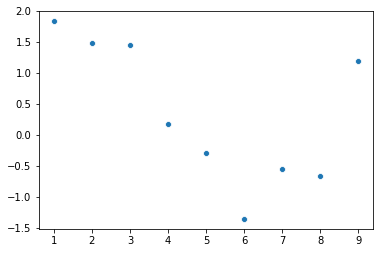

In [74]:
# visulize the parameters
logistic_pipe.fit(X_train, y_train)

logistic_coef = logistic_pipe.steps[1][1].coef_
_ = sns.scatterplot(x = range(1,logistic_coef.shape[1]+1), y = logistic_coef[0,:])

# Conclusion


From this simplified model, we can see that there are only 9 features included in the logistic regression. We have selected the best four features from our Task 5 analysis, and from this, we can attain the corresponding 9 coefficients. 

The linear nature of the logistic regression classifier makes it very interpretable, as it just requires plugging in the coefficients and test set vectors into a logistic regression sigmoid function in order to get the prediction. 

The accuracy is a few notches below our more Random Forest and Decision Trees, but its simplicity and interpretability is a valuable trade-off.